데이터 전처리

In [1]:
%pip install nltk
import nltk as nltk
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


Note: you may need to restart the kernel to use updated packages.


In [2]:
#파일 불러오기
print("Loading data file now, this could take a while depending on file size")
df = pd.read_csv('./amazon_uk_shoes_products_dataset_2021_12.csv')

Loading data file now, this could take a while depending on file size


In [3]:
#행열 갯수 알아보기
print("The shape of the data (rows, cols) is " + str(df.shape))

The shape of the data (rows, cols) is (6823, 11)


In [4]:
#감성 분석 시 필요한 review_text, review_rating만 사용
df = df[['review_text','review_rating']]

df.head()

,review_text,review_rating
0,Love these. Was looking for converses and thes...,5.0
1,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,5.0
3,Great,5.0
4,Ho scelto il modello bianco con rifinitura die...,5.0


In [5]:
def clean_text(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        text = re.sub(r'[^\w\s]', '', text)  # 알파벳과 공백을 제외한 모든 문자 제거
        text = text.lower()  # 소문자 변환
        text = text.strip()  # 양쪽 공백 제거
        return text
    else:
        return ""  # 문자열이 아닌 경우 빈 문자열 반환 또는 다른 처리 방법을 선택할 수 있음

# 클린업 함수 적용
df['review_text'] = df['review_text'].apply(clean_text)

print(df.head())

                                         review_text  review_rating
0  love these was looking for converses and these...            5.0
1  the shoes are very cute but after the 2nd day ...            2.0
2                                       good quality            5.0
3                                              great            5.0
4  ho scelto il modello bianco con rifinitura die...            5.0


In [6]:
#nltk 라이브러리를 사용하여 텍스트 토큰화 및 불용어 제거
#nltk에서 불용어 다운로드
nltk.download('punkt')
nltk.download('stopwords')

#불용어 리스트 가져오기
stop_words = set(stopwords.words("english"))

#토큰화 및 불용어 제거 함수
def tokenize_remove_stopwords(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return ''
    
#모든 리뷰 텍스트에 대해 토큰화 및 불용어 제거 적용
df['review_text'] = df['review_text'].apply(tokenize_remove_stopwords)

print(df.head())


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         review_text  review_rating
0  love looking converses half price unique ive n...            5.0
1  shoes cute 2nd day wearing tongue started ripp...            2.0
2                                       good quality            5.0
3                                              great            5.0
4  ho scelto il modello bianco con rifinitura die...            5.0


In [7]:
# 스테머 생성
stemmer = PorterStemmer()

# 스테밍 함수
def stem_text(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(stemmed_tokens)
    else:
        return ''
    
# 모든 리뷰 텍스트에 대해 스테밍 적용
df['review_text'] = df['review_text'].apply(stem_text)


print(df.head())


                                         review_text  review_rating
0  love look convers half price uniqu ive never s...            5.0
1  shoe cute 2nd day wear tongu start rip 3rd day...            2.0
2                                       good qualiti            5.0
3                                              great            5.0
4  ho scelto il modello bianco con rifinitura die...            5.0


모델 구현

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['review_text'])

# 감성 레이블 설정 (예: 4점 이상은 긍정, 3점 이하는 부정)
df['sentiment'] = df['review_rating'].apply(lambda x: 1 if x >= 4 else 0)
y = df['sentiment']

# 로지스틱 회귀 모델
model = LogisticRegression()

모델 학습 및 튜닝

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, classification_report
import numpy as np

In [75]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#모델 학습
model.fit(X_train, y_train)

#예측
predictions= model.predict(X_test) 

print('Presidiction labels: ', predictions)


Presidiction labels:  [0 1 1 ... 1 1 1]


In [76]:
# 하이퍼파라미터 튜닝- 그리드 서치
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

#그리드서치CV 객체 생성
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

#그리드 서치 실행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score: {:.4f}".format(grid_search.best_score_))


Best Hyperparameters: {'C': 10}
Best Score: 0.8349


In [57]:
# 교차 검증 함수 사용
scores = cross_validate(grid_search, X_train, y_train)
print(scores)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'fit_time': array([0.54816961, 0.58683228, 0.62246585, 0.58998036, 0.54085636]), 'score_time': array([0.0008893 , 0.00581002, 0.00090361, 0.00145364, 0.00089145]), 'test_score': array([0.82417582, 0.83241758, 0.82051282, 0.85334555, 0.84417965])}


In [58]:
# 교차 검증의 점수
print(np.mean(scores['test_score'])) 

0.8349262866678082


모델 평가

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [77]:
# 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

# 정밀도 계산
precision = precision_score(y_test, y_pred)

# 재현율 계산
recall = recall_score(y_test, y_pred)

# F1 점수 계산
f1 = f1_score(y_test, y_pred)

# ROC-AUC 계산 (positive 클래스에 대한 것만 계산)
roc_auc = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"정밀도: {precision:.4f}")
print(f"재현율: {recall:.4f}")
print(f"F1 점수: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


정확도: 0.8542
정밀도: 0.8714
재현율: 0.9467
F1 점수: 0.9075
ROC-AUC: 0.8960


언더피팅과 오버피팅
-	오버피팅은 Train 데이터에 모델이 너무 적합하게 학습되어 있기 때문에 Train 데이터가 아닌 다른 데이터가 들어오게 되면 정확도가 떨어지는 현상입니다.
오버피팅이 발생하면 모델은 훈련 데이터에서는 높은 성능을 보이지만, 새로운 데이터나 검증 데이터에서는 성능이 저하될 수 있습니다.

-	언더피팅은 모델이 너무 단순하거나, 학습 데이터의 다양성을 충분히 반영하지 못하는 경우 발생할 수 있습니다. 또한, 모델이 훈련 데이터의 패턴을 충분히 학습하지 못해, 훈련 데이터와 테스트 데이터 모두에서 성능이 낮은 상태를 말합니다

- 오버피팅 해결 방법
- 	데이터 양 늘리기
모델은 데이터의 양이 적을수록 해당 데이터의 특징 패턴이나 노이즈까지 암기해버려서 오버피팅 될 확률이 높습니다. 그래서 데이터의 양을 늘릴수록 모델은 일반적인 패턴을 학습하여 방지할 수 있습니다. 
-	모델의 복잡도 줄이기
모델의 능력을 줄인다고 표현할 수 있으며 이것은 데이터 양을 늘려주는 것과 반대로 학습하는 데이터의 수준에 맞게 모델의 능력을 조정해주는 방법입니다.

-	언더피팅 해결 방법
-	모델 복잡성 증가
모델의 복잡성을 높이거나, 다양한 특성을 추가하여 학습 데이터의 다양성을 반영하도록 합니다.
-	더 복잡한 모델 사용
모델의 복잡성을 늘려서 학습 데이터에 더 잘 맞출 수 있도록 합니다.

위 모델에서 훈련데이터의 성능은 0.8349, 검증 데이터의 성능은 0.8349262866로 성능이 낮지 않으며 밸런스가 맞음으로 오버피팅과 언더피팅에 해당하지 않습니다.


시각화 및 보고

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

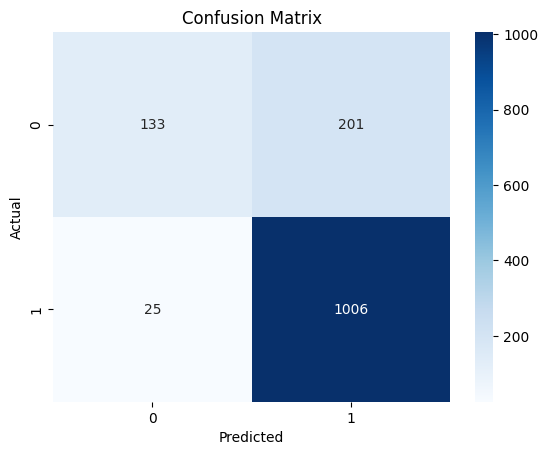

In [81]:
# 혼동 행렬 시각화
confusion_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


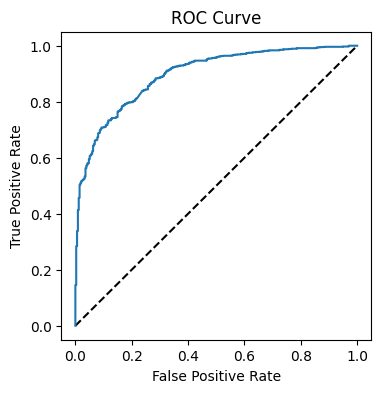

In [83]:
# ROC 곡선 시각화
y_score = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

fig= plt.figure(figsize=(4, 4))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()